In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

## Load the images

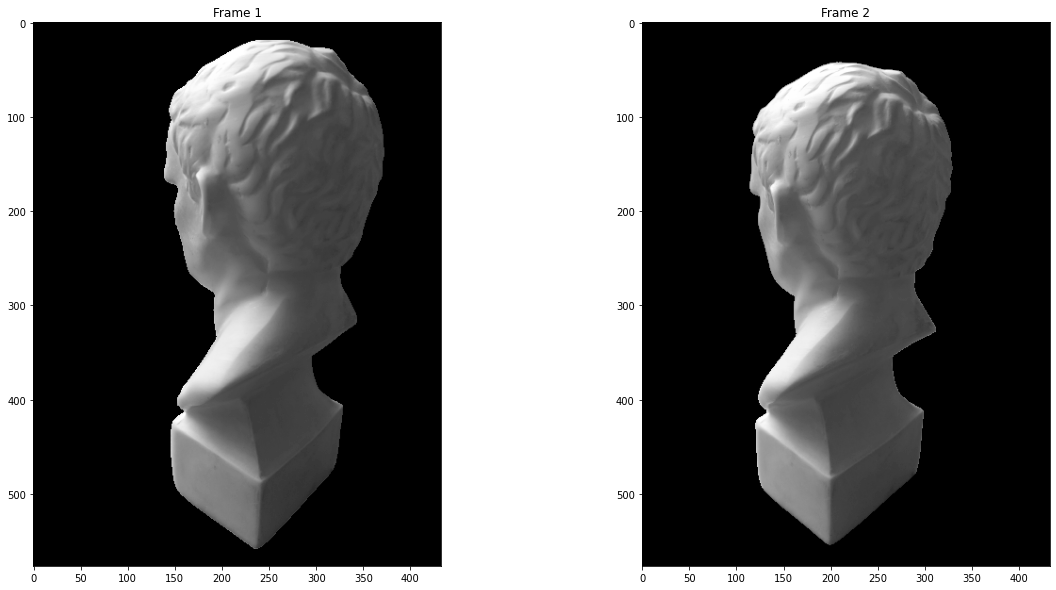

In [14]:
frames_path = os.path.join(os.getcwd(), 'Meesh')
frames = os.listdir(frames_path)

# load the first two frames
frame1 = cv2.imread(os.path.join(frames_path, frames[75]))
frame2 = cv2.imread(os.path.join(frames_path, frames[77]))

# convert to grayscale
frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# display the frames
fx, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].set_title("Frame 1")
plots[0].imshow(frame1_gray, cmap="gray")
plots[1].set_title("Frame 2")
plots[1].imshow(frame2_gray, cmap="gray")

## Feature Extraction

Number of Keypoints Detected In The Training Image:  131
Number of Keypoints Detected In The Query Image:  134


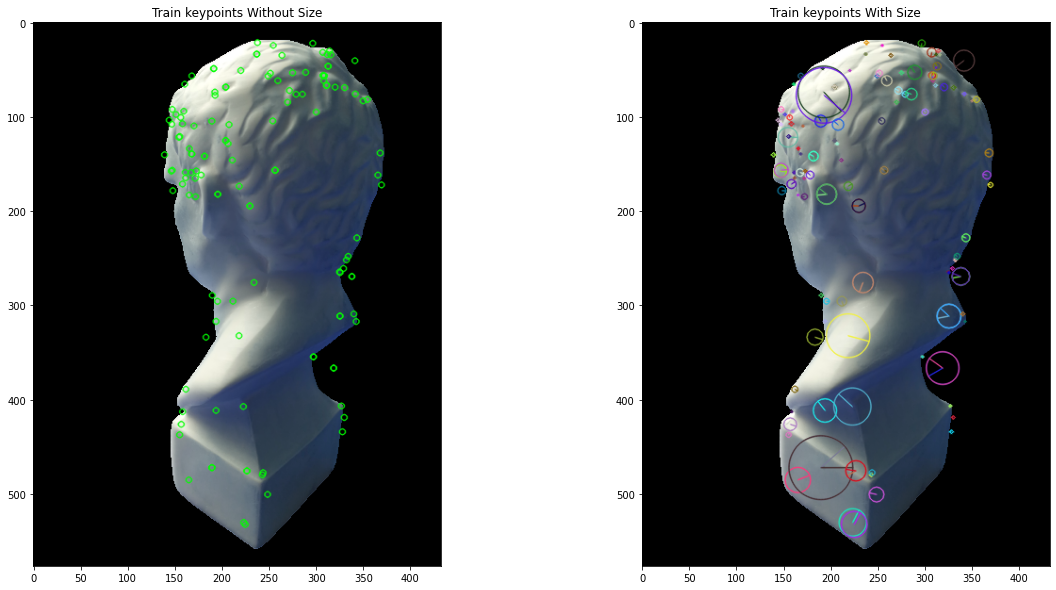

In [15]:
# detect the keypoints using SIFT
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT in each frame
kp1, des1 = sift.detectAndCompute(frame1_gray, None)
kp2, des2 = sift.detectAndCompute(frame2_gray, None)

keypoints_without_size = np.copy(frame1)
keypoints_with_size = np.copy(frame1)

cv2.drawKeypoints(frame1, kp1, keypoints_without_size, color = (0, 255, 0))
cv2.drawKeypoints(frame1, kp1, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fx, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].set_title("Train keypoints Without Size")
plots[0].imshow(keypoints_without_size, cmap="gray")
plots[1].set_title("Train keypoints With Size")
plots[1].imshow(keypoints_with_size, cmap="gray")

# print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(kp1))
# print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(kp2))


## Matching Keypoints

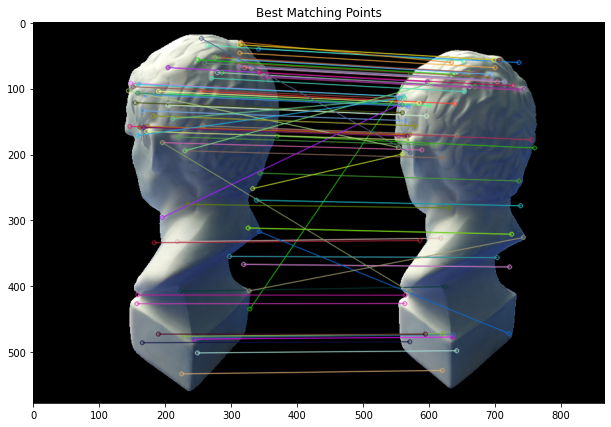


Number of Matching Keypoints Between The Training And Query Images:  82


In [16]:
# create a Brute force matcher object
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = True)

# Perform the matching between the SIFT descriptors of the training image and the test image
matches = bf.match(des1, des2)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(frame1, kp1, frame2, kp2, matches, None, flags = 2)

plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training And Query Images: ", len(matches))

## RANSAC algorithm
Removing outliers


Number of Inlier Matching Keypoints After RANSAC:  61


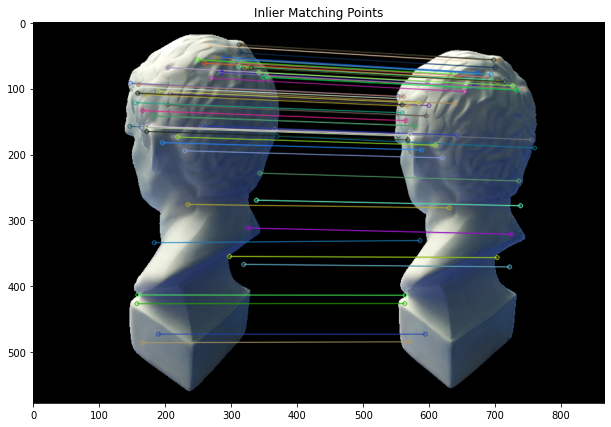

In [17]:
# RANSAC to find the best homography
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# RANSAC parameters
ransac_reproj_threshold = 9.0  # Adjust this threshold according to your application

# Find homography using RANSAC
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_reproj_threshold)

# Apply the mask to get the inliers (good matches)
inliers = [matches[i] for i in range(len(matches)) if mask[i] == 1]

# Print total number of matching points between the training and query images after RANSAC
print("\nNumber of Inlier Matching Keypoints After RANSAC: ", len(inliers))

# Draw the inlier matches
result_inliers = cv2.drawMatches(frame1, kp1, frame2, kp2, inliers, None, flags=2)

plt.title('Inlier Matching Points')
plt.imshow(result_inliers)
plt.show()


## Camera Pose Estimation

In [ ]:
import cv2
import numpy as np

# Step 1: Feature Extraction
def extract_features(image):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

# Step 2: Feature Matching
def match_features(descriptors1, descriptors2):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

# Step 3: Find Essential Matrix or Homography
def find_transform(matches, keypoints1, keypoints2):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Assuming perspective projection (essential matrix)
    E, _ = cv2.findEssentialMat(src_pts, dst_pts, focal=1.0, pp=(0, 0))

    # If planar projection, use findHomography
    # H, _ = cv2.findHomography(src_pts, dst_pts)

    return E

# Step 4: Recover Pose
def recover_pose(E, keypoints1, keypoints2):
    _, R, t, _ = cv2.recoverPose(E, keypoints1, keypoints2)
    return R, t

# Step 5: Visualize the Result (Optional)
def draw_axis(image, R, t, K, dist):
    axis_length = 0.1
    axis_points = np.float32([[0, 0, 0], [axis_length, 0, 0], [0, axis_length, 0], [0, 0, axis_length]]).reshape(-1, 3)

    # Project axis points to image plane
    image_points, _ = cv2.projectPoints(axis_points, R, t, K, dist)
    image_points = np.int32(image_points).reshape(-1, 2)

    # Draw axis lines on the image
    cv2.line(image, tuple(image_points[0]), tuple(image_points[1]), (0, 0, 255), 2)  # X-axis (red)
    cv2.line(image, tuple(image_points[0]), tuple(image_points[2]), (0, 255, 0), 2)  # Y-axis (green)
    cv2.line(image, tuple(image_points[0]), tuple(image_points[3]), (255, 0, 0), 2)  # Z-axis (blue)

    return image

if __name__ == "__main__":
    # Load two images
    # image1 = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)
    # image2 = cv2.imread('image2.jpg', cv2.IMREAD_GRAYSCALE)
    image1 = frame1
    image2 = frame2

    # Feature extraction and matching
    keypoints1, descriptors1 = extract_features(image1)
    keypoints2, descriptors2 = extract_features(image2)
    matches = match_features(descriptors1, descriptors2)

    # Find essential matrix
    E = find_transform(matches, keypoints1, keypoints2)

    # Recover pose
    K = np.array([[1000, 0, image1.shape[1] / 2], [0, 1000, image1.shape[0] / 2], [0, 0, 1]])  # Camera intrinsic matrix
    dist = np.zeros((4, 1))  # Distortion coefficients
    R, t = recover_pose(E, keypoints1, keypoints2)

    # Visualize the result
    result_image = draw_axis(image1, R, t, K, dist)

    cv2.imshow("Camera Pose Estimation", result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
